
## Import Libraries



In [14]:
import numpy as np
from numpy import argmax
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


## Data Preprocessing

In [5]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Filter for the classes we want (Cat, Dog, Airplane, Automobile)
selected_classes = [3, 5, 0, 1]  # 3: cat, 5: dog, 0: airplane, 1: automobile in the original dataset

# Create masks for train and test datasets
train_mask = np.isin(train_labels, selected_classes).reshape(-1)
test_mask = np.isin(test_labels, selected_classes).reshape(-1)

# Apply masks to datasets
train_images, train_labels = train_images[train_mask], train_labels[train_mask]
test_images, test_labels = test_images[test_mask], test_labels[test_mask]

# Map the labels to our new labels, and one-hot encoding labels
label_dict = {3: 0, 5: 1, 0: 2, 1: 3}
train_labels = tf.keras.utails.to_categorical([label_dict[label[0]] for label in train_labels])
test_labels = tf.keras.utils.to_categorical([label_dict[label[0]] for label in test_labels])

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define your data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Compute quantities required for featurewise normalization
datagen.fit(train_images)

training_data = datagen.flow(train_images, train_labels, batch_size=64)


## Modeling

### Baseline CNN

In [16]:
# from keras.models import Sequential
# from keras.layers import Conv2D, Dense, Flatten, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.optimizers import Adam, SGD
# from sklearn.model_selection import GridSearchCV

# # Define a function to create a Keras neural network model
# def create_model(hidden_layers=1, neurons=16, optimizer="adam"):
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    
#     for _ in range(hidden_layers - 1):
#         model.add(Conv2D(neurons, (3, 3), activation='relu'))
#         model.add(Dropout(0.2))
    
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4, activation='softmax'))
        
#     model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#     return model

# keras_clf = KerasClassifier(build_fn=create_model, verbose=0)

# param_grid = {
#     "hidden_layers": [2, 3],
#     "neurons": [16, 32],
#     'optimizer': ['adam', 'sgd'],
#     "batch_size": [20, 40],
#     "epochs": [10, 20],
# }

# grid_search = GridSearchCV(estimator=keras_clf, param_grid=param_grid, cv=3, n_jobs=1)

# # Fit the best estimator on the entire training dataset
# best_estimator = grid_search.best_estimator_
# best_estimator.fit(training_data)

In [12]:
# Model architecture
cnn_model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(4, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# Train the model using data augmentation generator
history = cnn_model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                        epochs=50, validation_data=(test_images, test_labels))

# Save model
cnn_model.save('cnn.h5')


Epoch 1/50
313/313 [==============================] - 18s 56ms/step - loss: 0.9773 - accuracy: 0.5407 - val_loss: 0.7213 - val_accuracy: 0.6805
Epoch 2/50
313/313 [==============================] - 17s 55ms/step - loss: 0.7510 - accuracy: 0.6622 - val_loss: 0.6224 - val_accuracy: 0.7228
Epoch 3/50
313/313 [==============================] - 18s 56ms/step - loss: 0.6696 - accuracy: 0.7088 - val_loss: 0.5408 - val_accuracy: 0.7730
Epoch 4/50
313/313 [==============================] - 18s 56ms/step - loss: 0.6364 - accuracy: 0.7254 - val_loss: 0.5253 - val_accuracy: 0.7825
Epoch 5/50
313/313 [==============================] - 18s 56ms/step - loss: 0.6082 - accuracy: 0.7431 - val_loss: 0.4831 - val_accuracy: 0.7977
Epoch 6/50
313/313 [==============================] - 18s 56ms/step - loss: 0.5809 - accuracy: 0.7552 - val_loss: 0.5031 - val_accuracy: 0.7793
Epoch 7/50
313/313 [==============================] - 18s 56ms/step - loss: 0.5569 - accuracy: 0.7684 - val_loss: 0.4700 - val_accuracy:

Evaluate the model


In [15]:
# First, get the probabilities
test_pred_probs = cnn_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = argmax(test_pred_probs, axis=1)

# Getting the classification report
print("CNN Classification Report:\n", classification_report(argmax(test_labels, axis=1), test_pred_classes))  # Convert one-hot to integers

# Calculating ROC AUC
roc_auc = roc_auc_score(argmax(test_labels, axis=1), test_pred_probs, multi_class='ovr')
print("CNN AUC:", roc_auc)

# Getting the confusion matrix
conf_mat = confusion_matrix(argmax(test_labels, axis=1), test_pred_classes)
print("CNN Confusion Matrix:\n", conf_mat)

125/125 [==============================] - 1s 9ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78      1000
           1       0.83      0.74      0.78      1000
           2       0.92      0.95      0.94      1000
           3       0.96      0.97      0.96      1000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

AUC: 0.9771002499999999
CNN Confusion Matrix:
 [[806 138  39  17]
 [220 738  33   9]
 [ 22   7 952  19]
 [  8   8  12 972]]


### Resnet

In [35]:
# Model architecture
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a new top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
res_model = Model(inputs=base_model.input, outputs=predictions)

# first, we only train the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
res_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
res_model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

# Save model
res_model.save('resnet.h5')

Epoch 1/10
250/250 [==============================] - 22s 81ms/step - loss: 1.2797 - accuracy: 0.4127 - val_loss: 1.1553 - val_accuracy: 0.5157
Epoch 2/10
250/250 [==============================] - 20s 78ms/step - loss: 1.1322 - accuracy: 0.4951 - val_loss: 1.0960 - val_accuracy: 0.5132
Epoch 3/10
250/250 [==============================] - 20s 78ms/step - loss: 1.0872 - accuracy: 0.5171 - val_loss: 1.0593 - val_accuracy: 0.5343
Epoch 4/10
250/250 [==============================] - 20s 78ms/step - loss: 1.0542 - accuracy: 0.5368 - val_loss: 1.0420 - val_accuracy: 0.5443
Epoch 5/10
250/250 [==============================] - 20s 79ms/step - loss: 1.0347 - accuracy: 0.5479 - val_loss: 1.0119 - val_accuracy: 0.5567
Epoch 6/10
250/250 [==============================] - 20s 78ms/step - loss: 1.0160 - accuracy: 0.5571 - val_loss: 1.0014 - val_accuracy: 0.5617
Epoch 7/10
250/250 [==============================] - 20s 79ms/step - loss: 1.0061 - accuracy: 0.5665 - val_loss: 0.9797 - val_accuracy:

Evaluate the model

In [36]:
# First, get the probabilities
test_pred_probs = res_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = argmax(test_pred_probs, axis=1)

# Getting the classification report
print("Resnet Classification Report:\n", classification_report(argmax(test_labels, axis=1), test_pred_classes))  # Convert one-hot to integers

# Calculating ROC AUC
roc_auc = roc_auc_score(argmax(test_labels, axis=1), test_pred_probs, multi_class='ovr')
print("AUC:", roc_auc)

125/125 [==============================] - 6s 46ms/step
Resnet Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.04      0.08      1000
           1       0.43      0.87      0.57      1000
           2       0.71      0.65      0.68      1000
           3       0.67      0.66      0.67      1000

    accuracy                           0.56      4000
   macro avg       0.59      0.55      0.50      4000
weighted avg       0.59      0.56      0.50      4000

AUC: 0.8436456666666666


### LeNet-5

In [37]:

# Model architecture
lenet_model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    AveragePooling2D(),
    Conv2D(16, (5, 5), activation='relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
lenet_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # We are not using logits but softmax in the last layer
              metrics=['accuracy'])

# Train the model
lenet_model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

# Save model
lenet_model.save('lenet.h5')

Epoch 1/10
250/250 [==============================] - 3s 10ms/step - loss: 0.9582 - accuracy: 0.5610 - val_loss: 0.7919 - val_accuracy: 0.6320
Epoch 2/10
250/250 [==============================] - 2s 9ms/step - loss: 0.7541 - accuracy: 0.6608 - val_loss: 0.6943 - val_accuracy: 0.6925
Epoch 3/10
250/250 [==============================] - 2s 9ms/step - loss: 0.6887 - accuracy: 0.6951 - val_loss: 0.6926 - val_accuracy: 0.6982
Epoch 4/10
250/250 [==============================] - 2s 9ms/step - loss: 0.6450 - accuracy: 0.7133 - val_loss: 0.6568 - val_accuracy: 0.7165
Epoch 5/10
250/250 [==============================] - 2s 9ms/step - loss: 0.6092 - accuracy: 0.7326 - val_loss: 0.6296 - val_accuracy: 0.7305
Epoch 6/10
250/250 [==============================] - 2s 9ms/step - loss: 0.5833 - accuracy: 0.7416 - val_loss: 0.6175 - val_accuracy: 0.7330
Epoch 7/10
250/250 [==============================] - 2s 9ms/step - loss: 0.5736 - accuracy: 0.7503 - val_loss: 0.5958 - val_accuracy: 0.7442
Epoch

Evaluate the model

In [25]:
# First, get the probabilities
test_pred_probs = lenet_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = argmax(test_pred_probs, axis=1)

# Getting the classification report
print("LeNet 5 Classification Report:\n", classification_report(argmax(test_labels, axis=1), test_pred_classes))  # Convert one-hot to integers

# Calculating ROC AUC
roc_auc = roc_auc_score(argmax(test_labels, axis=1), test_pred_probs, multi_class='ovr')
print("AUC:", roc_auc)

125/125 [==============================] - 0s 1ms/step
LeNet 5 Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.58      0.60      1000
           1       0.65      0.68      0.66      1000
           2       0.83      0.84      0.83      1000
           3       0.88      0.87      0.87      1000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000

AUC: 0.9290319166666666


### VGG-16

In [21]:
vgg_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
vgg_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
vgg_model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

# Save model
vgg_model.save('vgg.h5')


Epoch 1/10
250/250 [==============================] - 90s 355ms/step - loss: 1.3966 - accuracy: 0.2539 - val_loss: 1.3807 - val_accuracy: 0.2475
Epoch 2/10
250/250 [==============================] - 87s 347ms/step - loss: 1.3869 - accuracy: 0.2533 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/10
250/250 [==============================] - 88s 352ms/step - loss: 1.3865 - accuracy: 0.2469 - val_loss: 1.3856 - val_accuracy: 0.2475
Epoch 4/10
250/250 [==============================] - 88s 350ms/step - loss: 1.3866 - accuracy: 0.2479 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/10
250/250 [==============================] - 88s 352ms/step - loss: 1.3864 - accuracy: 0.2498 - val_loss: 1.3864 - val_accuracy: 0.2500
Epoch 6/10
250/250 [==============================] - 88s 352ms/step - loss: 1.3864 - accuracy: 0.2467 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 7/10
250/250 [==============================] - 88s 351ms/step - loss: 1.3864 - accuracy: 0.2455 - val_loss: 1.3863 - val_ac

Evaluate the model

In [23]:
# First, get the probabilities
test_pred_probs = vgg_model.predict(test_images)

# Then, convert the probabilities to class labels
test_pred_classes = argmax(test_pred_probs, axis=1)

# Getting the classification report
print("Resnet Classification Report:\n", classification_report(argmax(test_labels, axis=1), test_pred_classes))  # Convert one-hot to integers

# Calculating ROC AUC
roc_auc = roc_auc_score(argmax(test_labels, axis=1), test_pred_probs, multi_class='ovr')
print("AUC:", roc_auc)

125/125 [==============================] - 4s 34ms/step
Resnet Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.25      1.00      0.40      1000

    accuracy                           0.25      4000
   macro avg       0.06      0.25      0.10      4000
weighted avg       0.06      0.25      0.10      4000

AUC: 0.5


C:\Users\30640\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\30640\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\30640\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

## CNN Tuning

In [4]:



def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(4)  # 4 classes
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=3)

# define the grid search parameters
batch_size = [20, 60]
epochs = [10, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_images, train_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Predicting the classes
test_pred = grid.predict(test_images)

# Getting the classification report
print("Classification Report:\n", classification_report(argmax(test_labels, axis=1), test_pred))  # Convert one-hot to integers

# Calculating ROC AUC
roc_auc = roc_auc_score(argmax(test_labels, axis=1), grid.predict_proba(test_images), multi_class='ovr')
print("AUC:", roc_auc)

C:\Users\30640\AppData\Local\Temp\ipykernel_18304\2924262900.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=3)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Best: 0.789101 using {'batch_size': 60, 'epochs': 10}


In [ ]:
tuned_cnn_test_loss, tuned_cnn_test_acc

## Test image


1/1 [==============================] - 0s 26ms/step
The image is classified as: Cat


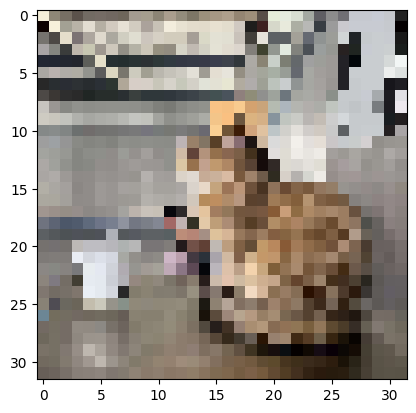

In [15]:
# Load the image
img_path = 'cat2.jpg'  # replace with your image path
img = image.load_img(img_path, target_size=(32, 32))

# Convert the image to a numpy array
x = image.img_to_array(img)

# Normalize the image
x = x / 255.0

# Add a dimension to transform the array into a "batch" of size (1, 32, 32, 3)
x = np.expand_dims(x, axis=0)

# Perform the prediction
preds = model.predict(x)

# Decode the prediction
pred_class = np.argmax(preds[0])

# Map the label index to the corresponding class
label_map = {0: 'Cat', 1: 'Dog', 2: 'Airplane', 3: 'Automobile'}  # adjust this to your classes
print(f'The image is classified as: {label_map[pred_class]}')

imgplot = plt.imshow(img)
plt.show()

In [ ]:
# Load the model
with CustomObjectScope({'dice_coef': dice_coef}):
    model = load_model('cnn.h5')